## Importing Libraries

Importing pandas for data handling, and numpy for math <br>
Using Plot style fivethirtyeight

In [1]:
# Importing libraries required to handle the data and matrix calculations
import pandas as pd
import numpy as np

# Importing libraries required for visualization
import matplotlib.pyplot as plt

# Importing libraries required for importing the data
from google.colab import files
import io

# For time measurements
import time

# Using plot style from fivethirtyeight
plt.style.use('fivethirtyeight')

## Neuron and Layers

* **Neuron Class:** The neuron class is just a representation of a neuron with a bias and incoming weights

* **Neuron Layer Class:** The layer class initializes a fully connected layer (Dense layer)based on the inputs and the number of neurons in this layer, uses the Neuron base class for neuron representation

The weight initialization is from the standard normal distribution ~ N(0,1).

The Bias is initialized with 0.

The Neuron Layer has the following properties:
* The Weights matrix shape is : [inputs x number of neurons in this layer]
* The biases in a layer, we have one bias per neuron and so the shape is: 
[1 x number of neurons in this layer]
* The fire function: Takes in the inputs and fires the layer, i.e. calculates the weighted sum of incoming weights and the input, adds the bias to get the output for the layer. WIth the output, calculates the ReLU activation, and the gradient of the activation
* ReLU (Rectified Linear Unit) activation function: f(x) = {0 if x<= 0; and x if x > 0} clips the value if its 0 or below, and is linear for any x > 0
* ReLU gradient: Assuming the derivative for ReLU at 0 approaches 0
* Other helper functions for updating the weights and biases


In [2]:
class Neuron:
  def __init__(self, w = None, b = None):
    self.weights = w
    self.bias = b

  def update(self, w, b):
    self.weights = w
    self.bias = b

  def __repr__(self):
    return f"{{My Bias = {self.bias} | Incoming Weights: {self.weights}}}"

class NeuronLayer:
  # Every layer has an input vector (x: previous layer output shape (nodes)) and an output vector (y: This layer output shape (nodes/workers))
  def __init__(self,n_inputs,n_neurons, weights = [], biases = []):
    self.input_nodes = n_inputs # Nodes in the previous layer (as they are input to this layer)
    self.output_nodes = n_neurons # Nodes in the layer
    
    if len(weights) == 0: # If no weights were provided
      self.weights = np.random.rand(self.input_nodes,self.output_nodes)
    else:
      self.weights = weights

    if len(biases) == 0: # If no biases were provided
      # self.biases = np.random.randn(1,self.output_nodes)
      self.biases = np.zeros((1,self.output_nodes))
    else:
      self.biases = biases

    # Creating the specific layer with the weights and biases for the Neurons
    self.layer = [Neuron(w,b) for b,w in zip(self.biases[0], self.weights.T)]

  def fire(self,training_input,activationFunction, gradientFunction):
    self.output = np.dot(training_input, self.weights) + self.biases
    self.activated_output = np.array([[activationFunction(c) for c in r] for r in self.output])
    self.activation_gradient = np.array([[gradientFunction(c) for c in r] for r in self.output])

  # Using Rectified Linear Unit activation function, if the value is negative return 0 otherwise unchanged value
  # f(x) = {0 if x<= 0; and x if x > 0}
  # Implementation is just a max{0,value}
  def relu(self,x):
    return np.maximum(0,x)

  # The derivative for f(x) = {0 if x <= 0; and x if x > 0}
  # f'(x) = { 0 if x <= 0; and 1 if x > 0} assuming the derivative for relu at 0 is 0 (as its approaching 0)
  def reluGradient(self,x):
    if x <= 0:
      return 0
    return 1

  # Some other activation functions and there derivatives
  # For classification, at the output layer a softmax is better than relu as it gives us a probability distribution
  # e^x is used to scale the values, and make them all positive
  # Then we normalize to get a probability distribution
  def softmax(self,x):
    exp_values = np.exp(x - np.max(x, axis = 1, keepdims = True))
    norm_values = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
    return norm_values;

  # Helper functions to adjust/update the weights and biases
  def getWeights(self):
    return self.weights
  def getBiases(self):
    return self.biases
  def setWeights(self,new_weights):
    self.weights = new_weights
  def setBiases(self,new_biases):
    self.biases = new_biases

  def updateLayer(self):
    for i,b,w in zip(range(self.output_nodes), self.biases[0], self.weights.T):
      self.layer[i].update(w,b) 

  def __repr__(self):
    return f"\n{self.layer}"

## Neural Network

The Neural Network class uses the Neuron layer class defined above to create a network of layers.

The input layer is created for representation purposes as it does nothing in the calculations as it has no incoming weights or biases.

The initialization of the Neural Network requires a list of neurons per layer, with the list provided the input, hidden and output layers are created.

The training of a neural network has 2 steps:
* Feed forward: In this step we just feed the data forward, starting from the provided input, the first hidden layer is given that input, the layer is fired where the activations are calculated, these output activation of this layer is used as the input for the next layer, and hence feed forward.

* Backpropagation: This is the main step where the error is calculated from the given labels and predicted output. With this error we calculate the gradient descent for the error (loss) function. 

The gradient descent for the output layer = 
error_derivative * activation_derivative

For weights: the Input to this layer is multiplied to get the weighted error based on the inputs, that is which input mattered more in this calculations and so which weights need to change more than others. It is then multiplied with learning rate to control the changes.

For biases: The gradient descent is summed up along the axis and then we have the biases per node based on the error and the learning rate.

Loss Functions:
Used basic squared error as it gives positive results, also tried mean squarred error and root mean squarred error.
The functions and their derivaties are used to calculate the gradient descent

The Fit Function: Takes input the whole training data, number of epochs, learning rate, error threshold and mini batch size.

Given these parameters, the fit function runs a loop for all the epochs.

    For every epoch:
      The training data is shuffled,
      The data is split into mini batches of the provided size,
      for every mini batch:
        We feed forward the mini batch and the error is calculated
        The error is backpropagated
    The netowrk weights and biases are updated once the training is complete.
    The fit method returns an array with errors for every epoch.

In [3]:
class NN:
  # layer_sizes format is a list of number of neurons per layer for example => [2,3,1] 2 input neurons, 3 hidden neurons and 1 output neuron
  def __init__(self,layer_sizes):
    # Network parameters initialization
    self.network_size = len(layer_sizes)
    self.input_nodes = layer_sizes[0]
    self.output_nodes = layer_sizes[self.network_size-1]
    self.hidden_layers = [None for _ in range(self.network_size-2)]
    self.layers = []

    # Initializing Network architecture/layers
    # For the provided structure we create the nodes/workers
    # The input layer is easy as it only has nodes for every input with no incomming weights and biases of its own
    # Creating this layer for representation purposes, doesnt have any work in the neural networks calculations
    self.input_layer = [Neuron() for _ in range(self.input_nodes)]
    
    # Creating Hidden layers
    for i in range(self.network_size -2): # Starting from 0 as input to first hidden layer is from the input layer
      self.hidden_layers[i] = NeuronLayer(layer_sizes[i],layer_sizes[i+1])
      self.layers.append(self.hidden_layers[i])

    # Creating Output Layer
    self.output_layer = NeuronLayer(layer_sizes[self.network_size-2],self.output_nodes)
    self.layers.append(self.output_layer)

  def epochRange(self, start, epochs):
    epoch = start
    while epoch < epochs:
      yield (epoch)
      epoch += 1

  def squaredError(self, predicted, true):
    error = 0.5*(true - predicted)**2
    return np.sum(error)

  def squaredGradient(self, predicted, true):
    return (true - predicted)
    
  # A mean squared cost function, takes the mean of the error term that is the squared diffrence between the predicted and expected value
  # mse = sum((x_true - x_predicted)^2)/2N = mean(0.5*(x_true - x_predicted)^2)
  def meanSquaredError(self,predicted,true):
    # Calculating the error
    error = true - predicted # [[predicted_i1, predicted_i2, ..., predicted_in]...] -[[true_i1, true_i2, ..., true_in]...] shape: rows=> number of samples in batch (b); col=> input features (n); => [b x n] matrix
    error = 0.5 * np.power(error, 2) # Squarred error [[error_sample1]**2,[error_sample2]**2, ..., [error_samplen]**2] => [b x n] matrix
    return np.mean(error) # Mean of the squared error within a batch, does nothing if batch size is 1 that is 1 sample at a time

  # The derivative of mse = sum((x_true - x_predicted)^2)/2N
  # mse' = (x_true - x_predicted)/N
  # Similar implementation as the mean squared error
  def mseGradient(self,predicted,true):
    error = true - predicted # [[predicted_i1, predicted_i2, ..., predicted_in]...] -[[true_i1, true_i2, ..., true_in]...] shape: number of samples in batch (b) x input features (n); => [b x n] matrix
    return error/true.size # Mean of the error within a batch, does nothing if batch size is 1 that is 1 sample at a time

  # Another cost function, takes the root of the mean squarred error
  def rootMeanSquaredError(self,predicted,true):
    # Calculating the error
    error = true - predicted # [[predicted_i1, predicted_i2, ..., predicted_in]...] -[[true_i1, true_i2, ..., true_in]...] shape: rows=> number of samples in batch (b); col=> input features (n); => [b x n] matrix
    error = np.power(error, 2) # Squarred error [[error_sample1]**2,[error_sample2]**2, ..., [error_samplen]**2] => [b x n] matrix
    return np.sqrt(np.mean(error)) # the square root of the mean squared error

  # The derivative for the rmse function
  def rmseGradient(self,predicted,true):
    return self.mseGradient(predicted,true)/(2*self.rootMeanSquarredError(predicted,true)) # d(rmse)/d(prev_activation) = (1/2*rmse)*mseGradient()
    
  def gradientDescent(self,error_gradient, activation_gradient):
    return error_gradient*activation_gradient

  def feedForward(self, training_batch):
    inp = training_batch # Input Layer

    for i in self.epochRange(0,self.network_size-2): # For every hidden layer (Total network layers - input layer - output layer)
      self.hidden_layers[i].fire(inp, self.hidden_layers[i].relu, self.hidden_layers[i].reluGradient)
      inp = self.hidden_layers[i].activated_output # Feeding the output forward as input
    
    # output layer (input is the output from the last layer (input/hidden layer))
    self.output_layer.fire(inp, self.output_layer.relu, self.output_layer.reluGradient)
    # print(f"Final output: {self.output_layer.activated_output}")

  # Going in reverse from the output layer to the first hidden layer in the network
  def backPropagation(self, training_batch, labels, lr, threshold, prev_error):
    # Calculating the error and the error gradient (the direction of the gradient ascent)
    error = self.squaredError(self.output_layer.activated_output,labels)
    error_gradient = self.squaredGradient(self.output_layer.activated_output,labels)
    # error = self.meanSquaredError(self.output_layer.activated_output,labels)
    # error_gradient = self.mseGradient(self.output_layer.activated_output,labels)

    # Calculating the asjustments for the output layer based on the error and the output layer activation gradient
    adjustments = self.gradientDescent(error_gradient, self.output_layer.activation_gradient)
    
    if self.network_size > 2: # If there is a hidden layer
      last_input = self.hidden_layers[-1].activated_output # The activated output of the last hidden layer
    else:
      last_input = training_batch # No hidden layer, the output layer is the only layer in the network

    # Calculating output layer adjustments based on the loss
    adjustments_wo = np.dot(last_input.T, adjustments) * lr
    output_bias = np.sum(adjustments,axis=0,keepdims=True) * lr

    adjustments_wh = []
    hidden_bias = []
    runCount = 0

    # For hidden layers, the adjustments from the previous layer is used and multiplied with the weights to get the gradient of cost with respect to the previous activation
    for i in range(self.network_size-3, -1, -1): # For every hidden layer (Total network layers - input layer - output layer)
      if runCount != 0:
        # Following hidden layers towards input layers
        adjustments = np.dot(adjustments, self.hidden_layers[i+1].weights.T)
        adjustments = adjustments * self.hidden_layers[i].activation_gradient
      else:
        # Last Hidden layer adjustments
        adjustments = np.dot(adjustments, self.output_layer.weights.T)
        adjustments = adjustments * self.hidden_layers[i].activation_gradient
        
      if i > 0: # If there are hidden layers
        last_input = self.hidden_layers[i-1].activated_output # The activated output of the last hidden layer
      else: # First hidden layer takes the provided input
        last_input = training_batch # No hidden layer, the output layer is the only layer in the network

      runCount += 1
      adjustments_wh.append(np.dot(last_input.T, adjustments) * lr)
      hidden_bias.append(np.sum(adjustments,axis=0,keepdims=True) * lr)
      

    # Updating the weights and biases from the calculated adjustments
    self.output_layer.setWeights(self.output_layer.getWeights() + adjustments_wo)
    self.output_layer.setBiases(self.output_layer.getBiases() + output_bias)

    for i,wh,bh in zip(range(self.network_size-3, -1, -1),adjustments_wh,hidden_bias):
      self.hidden_layers[i].setWeights(self.hidden_layers[i].getWeights() + wh)
      self.hidden_layers[i].setBiases(self.hidden_layers[i].getBiases() + bh)

    return error

  def fit(self,X_train,labels,epochs, mini_batch_size = 32,learningRate = 1e-1, threshold = 1e-5):
    lr = learningRate # Learning rate
    error = np.zeros((epochs+1,1))
    error[0] = np.inf # Starting with a very high error,a nd minimizing this using gradient descent
    training_data = np.hstack((X_train,labels))
    n = len(training_data)
    for epoch in self.epochRange(1,epochs+1): # For every epoch
      print(f"Epoch: {epoch} => ", end = "")
      start = time.time()

      # Shuffling the data
      np.random.shuffle(training_data)
      mini_batches = [training_data[k:k+mini_batch_size] for k in range(0, n, mini_batch_size)]
      m_count = 0

      for mini_batch in mini_batches: # For every mini batch
        if m_count % mini_batch_size == 0:
          print(".", end="")
        training_batch = mini_batch[:,:-self.output_layer.output_nodes] # Shuffled X_train
        training_labels = np.array([mini_batch[:,-self.output_layer.output_nodes]]).T # Shuffled Y_train

        # Run the feed forward
        self.feedForward(training_batch)

        #Calculating error and backpropogating the updates
        error[epoch] += self.backPropagation(training_batch, training_labels, learningRate, threshold, error[epoch-1])
        m_count += 1
      end = time.time()
      print(f" => Error: {error[epoch,0]}", end="")
      print(f"; Time taken: {end - start}")

    self.updateNetwork()
    return error[1:epoch+1]

  # Updates the network, sets the final values of the neuron after all backpropogation through every epoch. Only required for final representation of the network, as it updates all the neurons in every layer
  def updateNetwork(self):
    self.output_layer.updateLayer() # Updating the output layer neurons
    for i in self.epochRange(0,self.network_size-2): # For every hidden layer (Total network layers - input layer - output layer)
      self.hidden_layers[i].updateLayer() # Updating the hidden layer neurons

  def classify(self, x):
    if x >= 0.5:
      return 1
    return 0
  def classify2(self, x):
    if x >= 0.5:
      return 1
    return 0.5

  def __repr__(self):
    if self.network_size > 2:
      return f"Neural Network Architecture \n\nInput Layer=> \n{self.input_layer} \n\nHidden Layers=> {self.hidden_layers} \n\nOutput Layer=> {self.output_layer} \n"
    return f"Neural Network Architecture \n\nInput Layer=> \n{self.input_layer} \n\nOutput Layer=> {self.output_layer} \n"

##Loading and Pre-Processing the dataset

Cleaning the dataset, Dropping rows with NA values and resetting index

Encoding species to numerical values for the neural network to predict

Scaling the values for better training, and splitting the data into train and test datasets.

In [4]:
uploaded = files.upload()

Saving Iris.csv to Iris (1).csv


In [5]:
path = io.BytesIO(uploaded['Iris.csv'])
df = pd.read_csv(path)
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)
df = df.drop(["Id"],axis = 1)
df['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [6]:
#Mapping string species to numeric format
species_map = {'Iris-setosa':1, 'Iris-versicolor':2, 'Iris-virginica':3}
df['encoded_Species'] = df['Species'].map(species_map)
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,encoded_Species
0,4.6,3.2,1.4,0.2,Iris-setosa,1
1,5.9,3.0,4.2,1.5,Iris-versicolor,2
2,5.7,2.6,3.5,1.0,Iris-versicolor,2
3,4.4,3.0,1.3,0.2,Iris-setosa,1
4,6.7,2.5,5.8,1.8,Iris-virginica,3


In [7]:
# Iris dataset
target = 'encoded_Species'
predictors = list(df.columns)
predictors.remove("Species")
predictors.remove(target)

ndf = df.copy()
ndf.drop(ndf[ndf['encoded_Species'] == 3].index, inplace = True)
ndf.drop(["Species"], axis=1, inplace=True)

for c in predictors: # Scaled the features by dividing them from the maximum value of the column (MinMaxScaler, scaled values between [0,1])
  cNorm = ndf[c].max()
  ndf[c] = ndf[c]/cNorm

targetNorm = 2
ndf[target] = ndf[target]/targetNorm

X = ndf[predictors].values # Features to train on
y = np.array([ndf[target].values]).T # Target values for backpropagation

# Splitting into train and test
X_train = X[:80]
y_train = y[:80]
X_test = X[80:]
y_test = y[80:]

# XOR training data (Sample classification data)
X_train_xor = np.array([[0,0],
                    [0,1],
                    [1,0],
                    [1,1]])
y_train_xor = np.array([[0, 1, 1, 0]]).T

ndf.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,encoded_Species
0,0.657143,0.727273,0.274510,0.111111,0.5
1,0.842857,0.681818,0.823529,0.833333,1.0
2,0.814286,0.590909,0.686275,0.555556,1.0
3,0.628571,0.681818,0.254902,0.111111,0.5
5,0.771429,0.840909,0.294118,0.111111,0.5


## Training the Neural network

***Creating and fitting neural network***

**Architecture for XOR:** 2 Neurons in the input layer, 4 neurons in the hidden layer and 1 neuron in the output layer. This architecture using ReLU was able to converge and find a non-linear function for the XOR function.

**Architecture for Iris Dataset:** 4 Neurons in the input layer, 4 neurons in the first hidden layer, 4 neurons in the second hidden layer and 1 neuron in the output layer. This architecture using ReLU was able to converge and minimize the error.

**Iris Dataset**

In [8]:
np.random.seed(1) # Seeding for reproducibility
myNN = NN([X_train.shape[1], 4, 4, 1])
myNN

Neural Network Architecture 

Input Layer=> 
[{My Bias = None | Incoming Weights: None}, {My Bias = None | Incoming Weights: None}, {My Bias = None | Incoming Weights: None}, {My Bias = None | Incoming Weights: None}] 

Hidden Layers=> [
[{My Bias = 0.0 | Incoming Weights: [0.417022   0.14675589 0.39676747 0.20445225]}, {My Bias = 0.0 | Incoming Weights: [0.72032449 0.09233859 0.53881673 0.87811744]}, {My Bias = 0.0 | Incoming Weights: [1.14374817e-04 1.86260211e-01 4.19194514e-01 2.73875932e-02]}, {My Bias = 0.0 | Incoming Weights: [0.30233257 0.34556073 0.6852195  0.67046751]}], 
[{My Bias = 0.0 | Incoming Weights: [0.4173048  0.80074457 0.87638915 0.16983042]}, {My Bias = 0.0 | Incoming Weights: [0.55868983 0.96826158 0.89460666 0.8781425 ]}, {My Bias = 0.0 | Incoming Weights: [0.14038694 0.31342418 0.08504421 0.09834683]}, {My Bias = 0.0 | Incoming Weights: [0.19810149 0.69232262 0.03905478 0.42110763]}]] 

Output Layer=> 
[{My Bias = 0.0 | Incoming Weights: [0.95788953 0.53316528 

In [9]:
myNNerror = myNN.fit(X_train,y_train,epochs= 50, learningRate= 1e-4, mini_batch_size=8)
print("\nFinal Weights and Biases after training\n")
myNN

Epoch: 1 => .. => Error: 445.8858434994596; Time taken: 0.011890411376953125
Epoch: 2 => .. => Error: 252.5084223589054; Time taken: 0.009389400482177734
Epoch: 3 => .. => Error: 158.1908515377811; Time taken: 0.010048866271972656
Epoch: 4 => .. => Error: 105.82285318086656; Time taken: 0.01579451560974121
Epoch: 5 => .. => Error: 73.94213326350382; Time taken: 0.011810541152954102
Epoch: 6 => .. => Error: 53.48334770100115; Time taken: 0.013963460922241211
Epoch: 7 => .. => Error: 39.71531604256711; Time taken: 0.008313655853271484
Epoch: 8 => .. => Error: 30.285005519185866; Time taken: 0.0076558589935302734
Epoch: 9 => .. => Error: 23.560980926820577; Time taken: 0.008432388305664062
Epoch: 10 => .. => Error: 18.664142079867215; Time taken: 0.009134054183959961
Epoch: 11 => .. => Error: 14.998738336583466; Time taken: 0.00977325439453125
Epoch: 12 => .. => Error: 12.229755182947592; Time taken: 0.0061604976654052734
Epoch: 13 => .. => Error: 10.097513430036603; Time taken: 0.0109007

Neural Network Architecture 

Input Layer=> 
[{My Bias = None | Incoming Weights: None}, {My Bias = None | Incoming Weights: None}, {My Bias = None | Incoming Weights: None}, {My Bias = None | Incoming Weights: None}] 

Hidden Layers=> [
[{My Bias = -0.0803892874994408 | Incoming Weights: [0.34918589 0.0925053  0.33452877 0.14969134]}, {My Bias = -0.16309854688391218 | Incoming Weights: [ 0.58263959 -0.01770264  0.4123473   0.76679526]}, {My Bias = -0.15682835150602376 | Incoming Weights: [-0.13022629  0.07981838  0.30389934 -0.07223296]}, {My Bias = -0.06427290729160642 | Incoming Weights: [0.2489671  0.30187133 0.63835356 0.6299769 ]}], 
[{My Bias = -0.1099289972111727 | Incoming Weights: [0.3310099  0.6393085  0.85136054 0.01435284]}, {My Bias = -0.04451945598109543 | Incoming Weights: [0.52500206 0.9062311  0.8834904  0.8191352 ]}, {My Bias = -0.08776128681320511 | Incoming Weights: [ 0.07255536  0.18686658  0.066048   -0.0242616 ]}, {My Bias = -0.027967266261647493 | Incoming Weig

**XOR Sample training**

In [10]:
np.random.seed(1) # Seeding for reproducibility
xorNN = NN([2, 4, 1])
xorNN

Neural Network Architecture 

Input Layer=> 
[{My Bias = None | Incoming Weights: None}, {My Bias = None | Incoming Weights: None}] 

Hidden Layers=> [
[{My Bias = 0.0 | Incoming Weights: [0.417022   0.14675589]}, {My Bias = 0.0 | Incoming Weights: [0.72032449 0.09233859]}, {My Bias = 0.0 | Incoming Weights: [1.14374817e-04 1.86260211e-01]}, {My Bias = 0.0 | Incoming Weights: [0.30233257 0.34556073]}]] 

Output Layer=> 
[{My Bias = 0.0 | Incoming Weights: [0.39676747 0.53881673 0.41919451 0.6852195 ]}] 

In [11]:
xorNNerror = xorNN.fit(X_train_xor,y_train_xor, epochs = 100, learningRate = 1e-1, mini_batch_size=1)
print("\nFinal Weights and Biases after training\n")
xorNN

Epoch: 1 => .... => Error: 1.1739212150954308; Time taken: 0.002924680709838867
Epoch: 2 => .... => Error: 0.9302993177774549; Time taken: 0.00130462646484375
Epoch: 3 => .... => Error: 0.9156660354820574; Time taken: 0.009354352951049805
Epoch: 4 => .... => Error: 0.806539905837125; Time taken: 0.0049974918365478516
Epoch: 5 => .... => Error: 0.7435458527545515; Time taken: 0.004085063934326172
Epoch: 6 => .... => Error: 0.698988312429111; Time taken: 0.0058171749114990234
Epoch: 7 => .... => Error: 0.6539260511802513; Time taken: 0.0027112960815429688
Epoch: 8 => .... => Error: 0.6038137599882271; Time taken: 0.004849672317504883
Epoch: 9 => .... => Error: 0.6078838325782276; Time taken: 0.0017006397247314453
Epoch: 10 => .... => Error: 0.5626660115507242; Time taken: 0.0052225589752197266
Epoch: 11 => .... => Error: 0.5520255929837462; Time taken: 0.0012476444244384766
Epoch: 12 => .... => Error: 0.5221864636998907; Time taken: 0.008625984191894531
Epoch: 13 => .... => Error: 0.5075

Neural Network Architecture 

Input Layer=> 
[{My Bias = None | Incoming Weights: None}, {My Bias = None | Incoming Weights: None}] 

Hidden Layers=> [
[{My Bias = -0.00018583283458286455 | Incoming Weights: [0.22375846 0.02314295]}, {My Bias = 0.0003641611467616586 | Incoming Weights: [ 0.8843456  -0.88636131]}, {My Bias = 9.96420160869853e-05 | Incoming Weights: [-0.8202682   0.81741735]}, {My Bias = 7.211968794891565e-05 | Incoming Weights: [-0.13434171  0.13347095]}]] 

Output Layer=> 
[{My Bias = 0.0011216167959210474 | Incoming Weights: [0.04713602 1.11352813 1.1580428  0.35748617]}] 

## Testing the trained Neural Network

**Iris Dataset**

We can see the testing error is 0, that means the Neural network was able to converge and perform really well for binary classification on the dataset with 4 input features.

In [12]:
myNN.feedForward(X_test)
classifiedOutput = np.array([[myNN.classify2(a) for a in myNN.output_layer.activated_output]]).T
test_error = myNN.squaredError(classifiedOutput*targetNorm,y_test*targetNorm)
print(f"Error on the testing dataset: {test_error}")

Error on the testing dataset: 0.0


The 2 plots show the classification done by the neural network and the given classes.

Text(0.5, 0, 'Sepal Length (cm)')

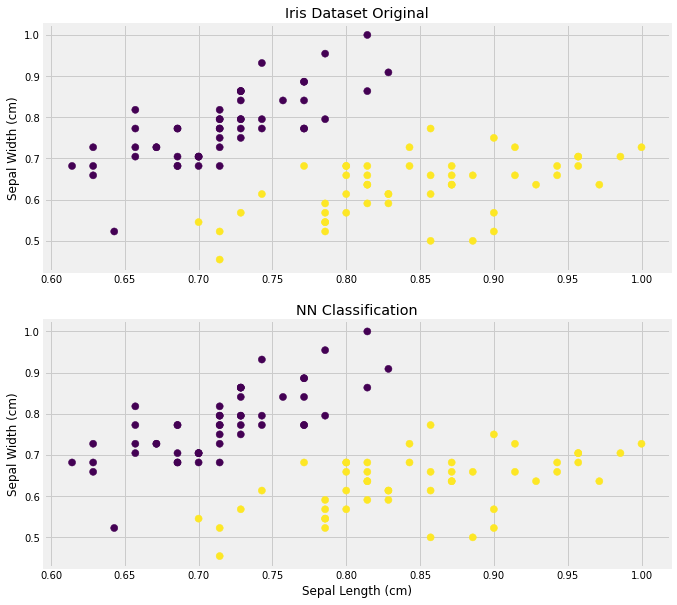

In [13]:
fig, axs = plt.subplots(2, figsize=(10,10))

axs[0].set_title("Iris Dataset Original")
axs[0].scatter(ndf['SepalLengthCm'], ndf['SepalWidthCm'], 50, c=ndf['encoded_Species'])
axs[0].set_ylabel('Sepal Width (cm)')

myNN.feedForward(X)
classifiedOutput_X = np.array([[myNN.classify2(a) for a in myNN.output_layer.activated_output]]).T

axs[1].set_title("NN Classification")
axs[1].scatter(ndf['SepalLengthCm'], ndf['SepalWidthCm'], 50, c=classifiedOutput_X)
axs[1].set_ylabel('Sepal Width (cm)')
axs[1].set_xlabel('Sepal Length (cm)')

**XOR output**

We can see the Neural network was able to learn the non-linear XOR function using a linear activation function.

In [14]:
nInp = [0,1]
xorNN.feedForward([nInp])
print(f"For Input {nInp} => Prediction: {xorNN.classify(xorNN.output_layer.activated_output[0])} => Actual Output: {nInp[0]^nInp[1]}\n")
xorNN.feedForward(X_train_xor)
print(f"All Inputs: {X_train_xor} \nPredicted Outputs: {[xorNN.classify(a) for a in xorNN.output_layer.activated_output]}; Actual Outputs: {y_train_xor.T}")

For Input [0, 1] => Prediction: 1 => Actual Output: 1

All Inputs: [[0 0]
 [0 1]
 [1 0]
 [1 1]] 
Predicted Outputs: [0, 1, 1, 0]; Actual Outputs: [[0 1 1 0]]


## Error analysis

Iris dataset loss function

From the graph we can see there is a smooth convergence, that is loss minimization with every epoch, the network kind of reaches the minimum around the 20th epoch and the error doesnt change much from there.

Text(0.5, 0, 'Epochs')

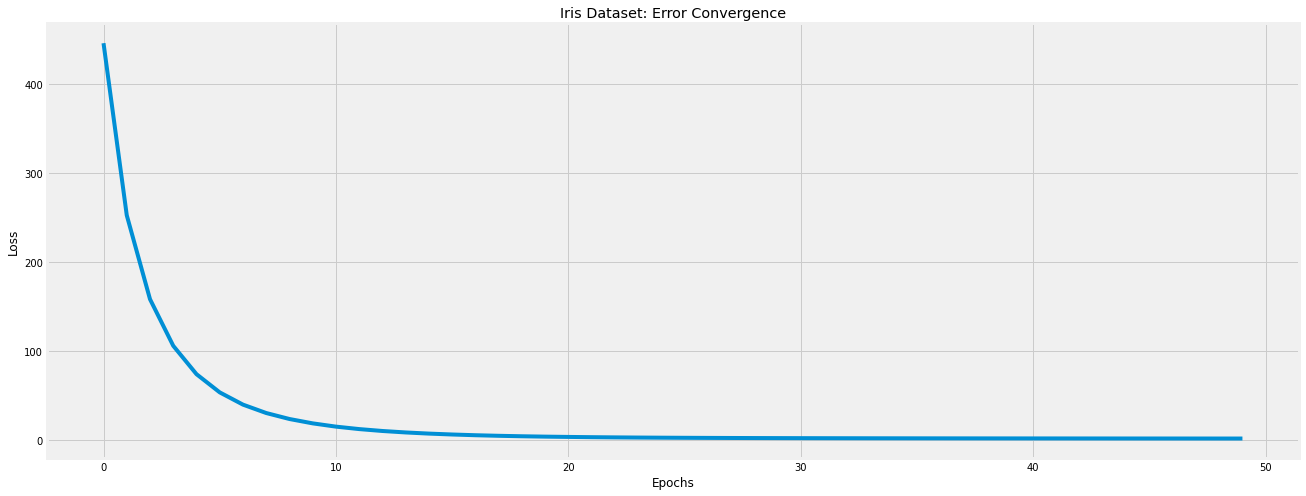

In [15]:
plt.figure(figsize=(20,8))
plt.title("Iris Dataset: Error Convergence")
ax = plt.plot(range(50), myNNerror)
plt.ylabel('Loss')
plt.xlabel('Epochs')

XOR Loss function

The XOR convergence looks interesting, the curve changes a lot based on the learning rate and the batch size used. The given curve is with a batch size of 1 (Like Stochastic Gradient Descent) and a learning rate of 0.1. The network reaches the minimum for the loss function around 60th-70th epoch and doesnt change much from there.

Text(0.5, 0, 'Epochs')

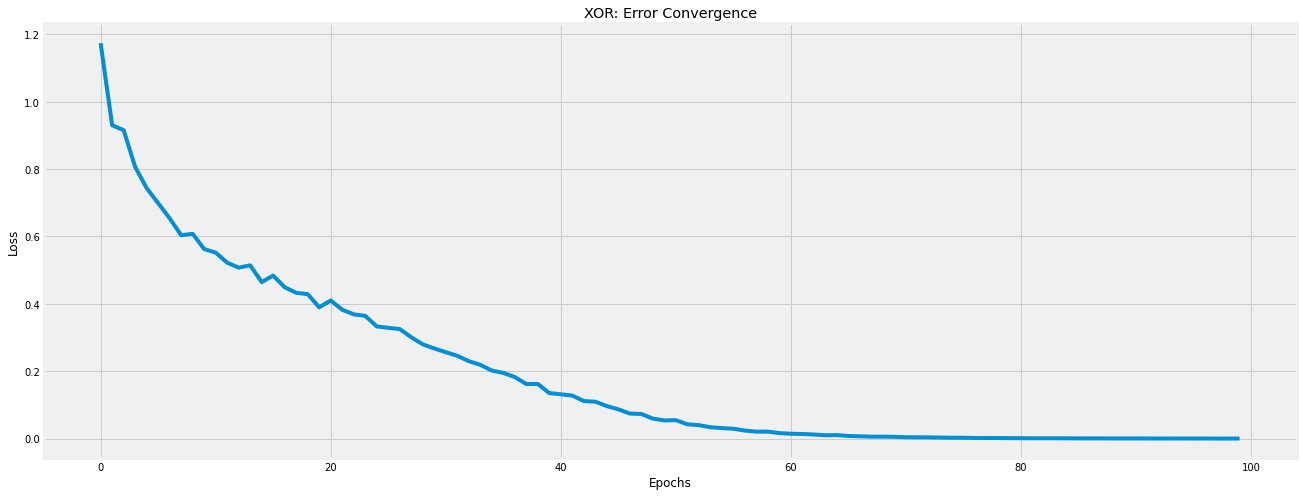

In [16]:
plt.figure(figsize=(20,8))
plt.title("XOR: Error Convergence")
ax = plt.plot(range(100), xorNNerror)
plt.ylabel('Loss')
plt.xlabel('Epochs')

**Observations:**
For a simple perceptron network, learning y = 5*x required a very small learning rate, as with gradient descent it was taking very big steps and never converging to a weight of 5.

For XOR sample data, using ReLU activation function, a simple network with 2 inputs, 2 hidden layer and 1 output layer didnt learn the non linearity for the XOR function where sigmoid/tanh have been shown to learn the non-linearity with that architecture. Whereas a model architecture of 2 inputs, 4 hidden layers, and 1 output layer using ReLU was able to converge to a very low error in 100 epochs with a learning rate of 0.1.

**Conclusion:** Neural Netowrks are pretty robust for many applications, while the functionality and the math behind the network is all linear but a combination of these linear nodes (ReLU activation) are able to adjust for the non-linearity required for many diffrent applications. The XOR function is an example where a NN is able to create a non-linear boundary where as any linear estimation will fail (a simple perceptron network will fail)

**Future work:** Implementaion of Binary Cross entropy or Cross entropy for the error/loss functions for classification will be an improvement. 
